In [1]:
import numpy as np
import csv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from tqdm import tqdm
import argparse

class AdmissionsDataset(Dataset):
    """Dataset class for loading and accessing admissions data."""
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return len(self.data)


class MLP(nn.Module):
    """Multi-layer perceptron model for classifying admissions data."""
    def __init__(self, input_dim=14, hidden_dim=64, output_dim=4):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.GELU()
    
    def forward(self, x):
        x = self.activation(self.lin1(x))
        x = self.activation(self.lin2(x))
        x = self.lin3(x)
        return x
    
    def save_representations(self, x):
        """Save intermediate representations for analysis."""
        np.save('data/original_rep.npy', x.detach().numpy())
        x = self.activation(self.lin1(x))
        np.save('data/layer1_rep.npy', x.detach().numpy())
        x = self.activation(self.lin2(x))
        np.save('data/layer2_rep.npy', x.detach().numpy())


class AdmissionsClassifier:
	"""Class for handling data loading, preprocessing, training, and testing the MLP model."""
	def __init__(self, args):
		self.batch_size = args.batch_size
		self.train_epoch = args.train_epoch
		self.lr = args.lr
		self.verbose = args.verbose
		self.data_path = args.data_path
		self.model = MLP()
	
	def load_data(self):
		"""Load and preprocess the data from the CSV file."""
		def to_float(input):
			return float(input) if input else -1

		def format_row(row):
			features = [to_float(row[col]) for col in 
						['satv_use', 'satm_use', 'satcomp_use', 'act_eng', 
						 'act_math', 'act_read', 'act_sci', 'act_comp', 
						 'nc1', 'nc2', 'nc3', 'ncav', 'hs_gpa', 'college_gpa']]
			# labels: [Admit, Denied, Waitlisted, Others]
			label = [0, 0, 0, 0]
			if row['vt_adm_dec'] == 'admitted':
				label[0] = 1
			elif row['vt_adm_dec'] == 'rejected':
				label[1] = 1
			elif row['vt_adm_dec'] == 'waitlisted':
				label[2] = 1
			return features, label

		with open(self.data_path, 'r', newline='', encoding='utf-8') as file:
			reader = csv.DictReader(file)
			data, labels = zip(*[format_row(row) for row in reader])

		data = np.array(data)
		data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0) + 1e-6)
		labels = np.array(labels)
		
		train_size = int(len(data) * 0.8)
		indices = list(range(len(data)))
		random.shuffle(indices)
		
		train_indices = indices[:train_size]
		test_indices = indices[train_size:]
		
		train_data = data[train_indices]
		test_data = data[test_indices]
		train_labels = labels[train_indices]
		test_labels = labels[test_indices]

		self.train_loader = DataLoader(AdmissionsDataset(train_data, train_labels), batch_size=self.batch_size, shuffle=True)
		self.test_loader = DataLoader(AdmissionsDataset(test_data, test_labels), batch_size=self.batch_size, shuffle=False)
	
	def train(self):
		"""Train the model on the training dataset."""
		optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
		criterion = nn.CrossEntropyLoss()
		
		for epoch in tqdm(range(self.train_epoch)):
			for batch_idx, (data, labels) in enumerate(self.train_loader):
				data = data.float()
				labels = labels.float()
				
				optimizer.zero_grad()
				predictions = self.model(data)
				loss = criterion(predictions, labels)
				loss.backward()
				optimizer.step()
				
				if batch_idx % self.verbose == 0:
					print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")
			print(f"Epoch {epoch}, Test Accuracy: {self.test_accuracy()}")
	
	def test_accuracy(self):
		"""Compute accuracy on the test dataset."""
		correct = 0
		total = 0
		with torch.no_grad():
			for data, labels in self.test_loader:
				data = data.float()
				predictions = self.model(data)
				predicted_labels = torch.argmax(predictions, dim=1)
				actual_labels = torch.argmax(labels, dim=1)
				correct += (predicted_labels == actual_labels).sum().item()
				total += labels.size(0)
		return correct / total
	
	def save_representations(self):
		"""Save representations from various model layers."""
		sample_data, _ = next(iter(self.train_loader))
		self.model.save_representations(sample_data.float())

		

In [2]:
# Parsing arguments
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', 
                    type=int, 
                    default=300, 
                    help='the number of data samples processed together in one forward and backward pass')
parser.add_argument('--train_epoch', type=int, default=5)
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate hyperameter')
parser.add_argument('--verbose', type=int, default=10)
parser.add_argument('--data_path', type=str, default='data.csv')
args = parser.parse_args(args=['--data_path', 'data/ext_dataset1.csv'])

model = AdmissionsClassifier(args)
model.load_data()
model.train()
model.save_representations()

100%|██████████| 5/5 [00:00<00:00, 19.58it/s]

Epoch 0, Batch 0, Loss: 1.4114701747894287
Epoch 0, Test Accuracy: 0.2
Epoch 1, Batch 0, Loss: 1.3998496532440186
Epoch 1, Test Accuracy: 0.25
Epoch 2, Batch 0, Loss: 1.388471245765686
Epoch 2, Test Accuracy: 0.225
Epoch 3, Batch 0, Loss: 1.377286672592163
Epoch 3, Test Accuracy: 0.475
Epoch 4, Batch 0, Loss: 1.3662422895431519
Epoch 4, Test Accuracy: 0.5


In [3]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[[ 0.24806336 -0.05367988  0.46519136 ...  0.30358076 -0.28710026
   0.2567064 ]
 [-0.22192657  0.16236138  0.41230398 ...  0.25957492 -0.61735916
   0.2519289 ]
 [ 0.2268408   0.5629635   0.6423097  ... -0.00543987 -0.5013166
   0.27211872]
 ...
 [ 0.26402205  0.15061644  0.53234833 ...  0.12542695  0.2727387
   0.3239531 ]
 [ 0.17541152 -0.06081814  0.29308888 ...  0.10242789 -0.0197804
   0.10364062]
 [ 0.2820229   0.21248624  0.53331023 ...  0.2467019   0.23186655
   0.56544495]]


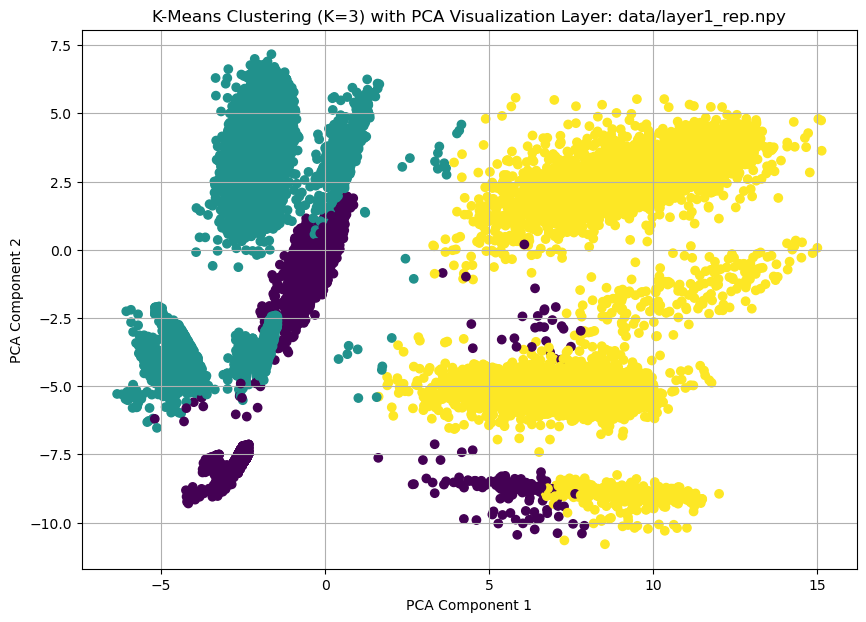

[[ 0.7918929  -0.03500574  0.15317836 ... -0.16689375  0.26537642
   0.1264763 ]
 [-0.11659811  0.13322756 -0.09020749 ... -0.21568291 -0.27100772
  -0.31162953]
 [-0.00659656 -0.01827186 -0.19188295 ...  0.46271914 -0.19809902
  -0.5052831 ]
 ...
 [ 0.75058955  0.01709707  0.0740801  ...  0.17493372  0.38004944
  -0.08448386]
 [ 0.7221271   0.22874245  0.16002621 ... -0.26786456  0.38421276
   0.10075401]
 [ 0.9580328  -0.04447267  0.00522666 ...  0.41981637  0.4507514
  -0.18470313]]


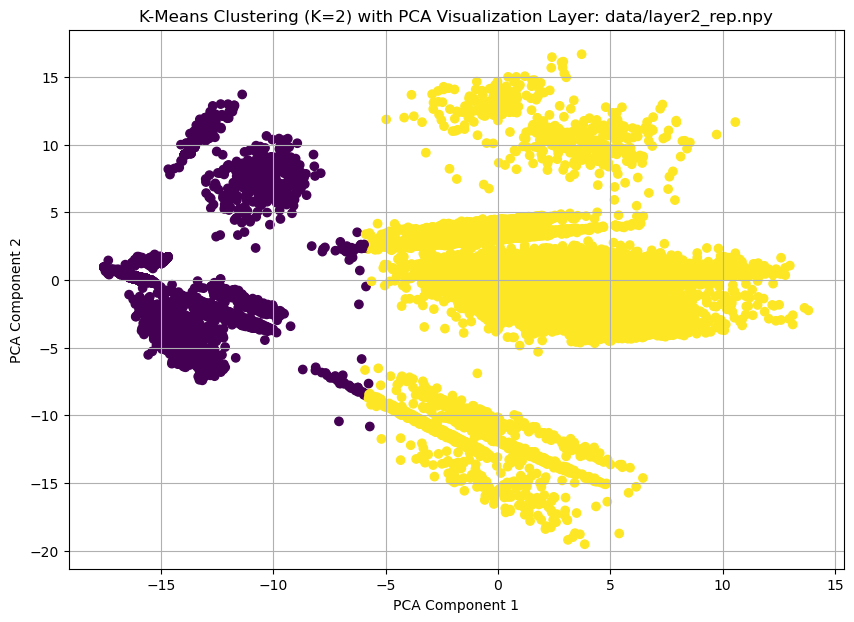

In [19]:
def cluster_with_pca(npy_file_path='data/original_rep.npy', n_clusters=3):
	scaler = StandardScaler()
	layer1_rep = np.load(npy_file_path)
	print(layer1_rep)
	data_standardized = scaler.fit_transform(layer1_rep)

	kmeans = KMeans(n_clusters=n_clusters, random_state=42)
	kmeans.fit(data_standardized)
	labels = kmeans.labels_

	pca = PCA(n_components=2)
	reduced_data = pca.fit_transform(data_standardized)

	plt.figure(figsize=(10, 7))
	scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
	# plt.colorbar(scatter)
	plt.title("K-Means Clustering (K={}) with PCA Visualization Layer: {}".format(n_clusters, npy_file_path))
	plt.xlabel("PCA Component 1")
	plt.ylabel("PCA Component 2")
	plt.grid(True)
	plt.show()

cluster_with_pca('data/layer1_rep.npy', 3)
cluster_with_pca('data/layer2_rep.npy', 2)


PCA reveals the presece of clusters within the original dataset based on all columns suggesting that the data exhibits inherent groupings. This allows us to proceed with a more detailed analysis using specific clustering metrics to understand patterns.

In [22]:
from sklearn.cluster import DBSCAN
npy_file_path='data/layer1_rep.npy'

scaler = StandardScaler()
layer1_rep = np.load(npy_file_path)
data_standardized = scaler.fit_transform(layer1_rep)

dbscan = DBSCAN(eps = 0.5, min_samples = 5) #change eps and min_samp as needed
clusters = dbscan.fit_predict(data_standardized)
print(clusters)
#layer1_rep["cluster"] = clusters


[-1 -1  0 ... -1 -1 -1]


1. how meaningful are layer1 and layer2 representations for the specific clustering tasks we had mentioned before, since they are numerical representations meant for classification? 

2. found existance of clusters using pca and dbscan, but not sure what those are. 

3. generated data from the three rows that we had but unable to create extended dataset that had meaningful correlation between test scores, gpas, and labels (admission result).